# Necessary Imports and Data Readings


In [1]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import glob
from pathlib import Path

# Sobel Edge Detector


In [2]:
def sobel_edge_detector(image_path, kernel_size=3):
    """
    Apply Sobel edge detection to an image.

    Args:
    - image_path (str): Path to the input image.
    - kernel_size (int): Size of the Gaussian kernel for blurring. Must be odd and greater than 1.

    Returns:
    - Tuple of (grad_mag, grad_x, grad_y):
        - grad_mag (numpy.ndarray): Gradient magnitude image, scaled and converted to 8-bit unsigned integer.
        - grad_x (numpy.ndarray): Gradient in the x-direction.
        - grad_y (numpy.ndarray): Gradient in the y-direction.
    """
    if kernel_size % 2 == 0 or kernel_size <= 1:
        raise ValueError("Kernel size must be odd and greater than 1.")

    # Read the image from the specified path
    img = cv2.imread(image_path)

    if img is None:
        raise FileNotFoundError(
            f"The specified image path does not exist: {image_path}"
        )

    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to smooth the image and reduce noise,
    # which helps in the edge detection process
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

    # Define Sobel kernels for x and y directions
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Apply convolution with the Sobel kernels to detect edges in x and y directions
    grad_x = cv2.filter2D(blurred_image, cv2.CV_64F, kernel_x)
    grad_y = cv2.filter2D(blurred_image, cv2.CV_64F, kernel_y)

    # Calculate the gradient magnitude as the Euclidean norm of gradients in x and y directions
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)

    # Convert gradient magnitude to 8-bit unsigned integer type for displaying
    # The convertScaleAbs function scales the gradient magnitude to the full 8-bit range
    grad_mag_uint8 = cv2.convertScaleAbs(grad_mag)

    return grad_mag_uint8, grad_x, grad_y

# Canny Edge Detector


In [3]:
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    """
    Suppresses non-maximum gradient magnitudes to thin out edges.

    Args:
        gradient_magnitude (numpy.ndarray): The gradient magnitudes of the image.
        gradient_direction (numpy.ndarray): The directions of the gradients.

    Returns:
        numpy.ndarray: The suppressed image.
    """
    rows, cols = gradient_magnitude.shape
    suppressed = np.zeros_like(gradient_magnitude)
    angle = gradient_direction * 180.0 / np.pi  # Convert to degrees
    angle[angle < 0] += 180  # Map angles to 0-180 degrees

    # Define angle ranges for edge direction
    angle_mask = np.zeros_like(angle, dtype=bool)

    for direction, angles in enumerate(
        [(0, 22.5, 157.5, 180), (22.5, 67.5), (67.5, 112.5), (112.5, 157.5)]
    ):
        # Create mask for current direction
        if len(angles) == 4:  # Special case for East-West including 0 and 180 degrees
            angle_mask |= (angle >= angles[0]) & (angle < angles[1]) | (
                angle >= angles[2]
            ) & (angle <= angles[3])
        else:
            angle_mask |= (angle >= angles[0]) & (angle < angles[1])

        # Determine neighbor pixels based on edge direction
        if direction == 0:  # East-West
            q = np.roll(gradient_magnitude, -1, axis=1)
            r = np.roll(gradient_magnitude, 1, axis=1)
        elif direction == 1:  # Northeast-Southwest
            q = np.roll(np.roll(gradient_magnitude, -1, axis=0), -1, axis=1)
            r = np.roll(np.roll(gradient_magnitude, 1, axis=0), 1, axis=1)
        elif direction == 2:  # North-South
            q = np.roll(gradient_magnitude, -1, axis=0)
            r = np.roll(gradient_magnitude, 1, axis=0)
        elif direction == 3:  # Northwest-Southeast
            q = np.roll(np.roll(gradient_magnitude, -1, axis=0), 1, axis=1)
            r = np.roll(np.roll(gradient_magnitude, 1, axis=0), -1, axis=1)

        # Suppress non-maximum pixels
        suppressed = np.where(
            ((gradient_magnitude >= q) & (gradient_magnitude >= r) & angle_mask),
            gradient_magnitude,
            suppressed,
        )

    return suppressed

In [4]:
def double_threshold(image, low_threshold_ratio, high_threshold_ratio):
    """
    Applies double threshold to detect strong, weak, and non-relevant pixels.

    Args:
        image (numpy.ndarray): The suppressed image.
        low_threshold_ratio (float): Ratio for the low threshold.
        high_threshold_ratio (float): Ratio for the high threshold.

    Returns:
        numpy.ndarray: The thresholded image.
    """
    high_threshold = image.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio

    strong = 255
    weak = 25

    strong_i, strong_j = np.where(image >= high_threshold)
    weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

    result = np.zeros_like(image)
    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak

    return result

In [5]:
def edge_tracking_by_hysteresis(image, weak=25, strong=255):
    """
    Tracks and connects weak edge pixels to strong edge pixels.

    Args:
        image (numpy.ndarray): The double thresholded image.
        weak (int): The value used to represent weak edges.
        strong (int): The value used to represent strong edges.

    Returns:
        numpy.ndarray: The final edge detected image after hysteresis.
    """
    rows, cols = image.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if image[i, j] == weak:
                # Check if one of the neighbors is a strong pixel
                if np.any(image[i - 1 : i + 2, j - 1 : j + 2] == strong):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

In [6]:
def canny_edge_detector(
    image_path, kernel_size=5, low_threshold_ratio=0.1, high_threshold_ratio=0.5
):
    """
    Performs Canny edge detection.

    Args:
        image_path (str): Path to the input image.
        kernel_size (int): Size of the Gaussian kernel for blurring.
        low_threshold_ratio (float): Lower bound for thresholding.
        high_threshold_ratio (float): Upper bound for thresholding.

    Returns:
        numpy.ndarray: The edge-detected image.
    """
    # Preliminary steps: Sobel edge detection
    gradient_mag, grad_x, grad_y = sobel_edge_detector(image_path, kernel_size)

    # Calculate gradient direction
    gradient_dir = np.arctan2(grad_y, grad_x)

    # Step 1: Non-maximum suppression
    suppressed = non_maximum_suppression(gradient_mag, gradient_dir)

    # Step 2: Double thresholding
    thresholded = double_threshold(
        suppressed, low_threshold_ratio, high_threshold_ratio
    )

    # Step 3: Edge tracking by hysteresis
    edges = edge_tracking_by_hysteresis(thresholded)

    return edges.astype(np.uint8)

# Hough Transform With Canny & Sobel


In [7]:
def hough_lines(
    image,
    rho_resolution=1,
    theta_resolution=np.pi / 180,
    threshold=150,
    top_n_lines=None,
):
    """
    Detects lines in an edge image using the Hough Transform, with an option to filter for the top N lines.

    Args:
        image (numpy.ndarray): The edge-detected image.
        rho_resolution (int): The resolution of rho in pixels.
        theta_resolution (float): The resolution of theta in radians.
        threshold (int): The threshold for the accumulator to consider a line.
        top_n_lines (int, optional): If provided, only the top N lines with the highest votes are returned.

    Returns:
        list of tuples: A list of (rho, theta) tuples representing detected lines.
    """
    height, width = image.shape
    max_rho = int(np.ceil(np.sqrt(height**2 + width**2)))
    num_thetas = int(np.round(np.pi / theta_resolution))
    thetas = np.linspace(0, np.pi, num_thetas)

    accumulator = np.zeros((2 * max_rho, num_thetas), dtype=np.int32)
    y_idxs, x_idxs = np.nonzero(image)
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]) + max_rho)
            accumulator[rho, t_idx] += 1

    # Optionally filter for the top N lines
    if top_n_lines:
        # Flatten the accumulator, sort it, and pick top N indices
        flat_accumulator = accumulator.flatten()
        sorted_indices = np.argsort(flat_accumulator)[::-1][:top_n_lines]
        rho_idxs, theta_idxs = np.unravel_index(sorted_indices, accumulator.shape)
    else:
        rho_idxs, theta_idxs = np.nonzero(accumulator > threshold)

    rhos = rho_idxs - max_rho
    lines = [(rhos[i], thetas[theta_idxs[i]]) for i in range(len(rho_idxs))]

    return lines

In [8]:
def draw_lines(image, lines, line_color=(0, 255, 0), thickness=2):
    """
    Draws lines on an image given in Hough space (rho, theta).

    Args:
        image (numpy.ndarray): The original image.
        lines (list of tuples): Lines represented as (rho, theta).
        line_color (tuple): Color of the lines.
        thickness (int): Thickness of the lines.
    """
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # Points far enough to draw line across the image
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), line_color, thickness)

In [9]:
def visualize_edges_lines_boxes(edges, lines_img, bbox_img):
    """
    Visualizes edge detection result, Hough lines, and bounding boxes on images.

    Args:
        edges (numpy.ndarray): Edge-detected image.
        lines_img (numpy.ndarray): Image with Hough lines drawn.
        bbox_img (numpy.ndarray): Image with bounding boxes drawn.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(edges, cmap="gray")
    axes[0].set_title("Edge Detected")
    axes[0].axis("off")

    axes[1].imshow(lines_img)
    axes[1].set_title("Hough Lines")
    axes[1].axis("off")

    axes[2].imshow(bbox_img)
    axes[2].set_title("Bounding Boxes")
    axes[2].axis("off")

    plt.show()

# Find Plates


In [10]:
def predict_plate(image, lines, real_coordinates):
    """
    Predicts the license plate area based on Hough lines and calculates the IoU against real coordinates.

    Args:
        image (numpy.ndarray): Original image array.
        lines (list of tuples): Detected lines as (rho, theta) pairs from Hough Transform.
        real_coordinates (tuple): The ground truth bounding box of the license plate (x1, y1, x2, y2).

    Returns:
        float: The Intersection over Union (IoU) of the predicted plate area and the real plate area.
    """
    # Ensure lines are in correct format for draw_lines
    if lines is None:
        print("No lines were detected or provided.")
        return 0

    # Draw detected lines and predicted bounding box based on those lines
    # Draw detected lines for visualization
    lines_img = np.copy(image)
    for line in lines:  # Assuming line is a tuple of (rho, theta)
        draw_lines(lines_img, [line], line_color=(0, 255, 0), thickness=2)

    # Extract real_coordinates for drawing
    x1, y1, x2, y2 = real_coordinates

    # Create mask from lines to predict plate area
    mask = np.zeros_like(image[:, :, 0])
    for line in lines:
        draw_lines(mask, [line])

    y_nonzero, x_nonzero = np.nonzero(mask)

    if x_nonzero.size > 0 and y_nonzero.size > 0:
        x_top, x_bottom = np.min(x_nonzero), np.max(x_nonzero)
        y_top, y_bottom = np.min(y_nonzero), np.max(y_nonzero)
        # Proceed with using x_top, x_bottom, y_top, y_bottom as needed
    else:
        print(
            "No lines detected in the image, or lines did not modify the mask as expected."
        )

    # Drawing rectangles for visualization
    bbox_image = np.copy(image)
    cv2.rectangle(bbox_image, (x_top, y_top), (x_bottom, y_bottom), (255, 0, 0), 2)
    cv2.rectangle(bbox_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Calculate IoU
    x_left = max(x_top, x1)
    y_top = max(y_top, y1)
    x_right = min(x_bottom, x2)
    y_bottom = min(y_bottom, y2)

    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)
    predicted_area = (x_bottom - x_top) * (y_bottom - y_top)
    real_area = (x2 - x1) * (y2 - y1)
    union_area = predicted_area + real_area - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[1].imshow(cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Detected Lines")
    axes[2].imshow(cv2.cvtColor(bbox_image, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Predicted vs Real BBox")
    for ax in axes:
        ax.axis("off")
    plt.show()

    return iou

In [11]:
def find_intersections(horizontal_lines, vertical_lines):
    """
    Find intersections between horizontal and vertical lines.

    Args:
        horizontal_lines (list of tuples): Horizontal lines (rho, theta).
        vertical_lines (list of tuples): Vertical lines (rho, theta).

    Returns:
        list of tuples: Intersection points (x, y).
    """
    intersections = []
    for rho_h, theta_h in horizontal_lines:
        for rho_v, theta_v in vertical_lines:
            matrix = np.array(
                [[np.cos(theta_h), np.sin(theta_h)], [np.cos(theta_v), np.sin(theta_v)]]
            )
            vector = np.array([rho_h, rho_v])
            intersection = np.linalg.solve(matrix, vector)
            intersections.append(tuple(intersection))
    return intersections

In [12]:
def group_lines_by_orientation(lines, theta_threshold=np.pi / 18):
    """
    Group lines into horizontal and vertical based on their theta values.

    Args:
        lines (list of tuples): List of (rho, theta) tuples from Hough Transform.
        theta_threshold (float): Threshold to categorize near-horizontal or near-vertical lines.

    Returns:
        tuple: Two lists containing horizontal and vertical lines respectively.
    """
    horizontal_lines = []
    vertical_lines = []

    for rho, theta in lines:
        # Horizontal lines: theta near pi/2
        if np.pi / 2 - theta_threshold <= theta <= np.pi / 2 + theta_threshold:
            horizontal_lines.append((rho, theta))
        # Vertical lines: theta near 0 or pi
        elif theta <= theta_threshold or theta >= np.pi - theta_threshold:
            vertical_lines.append((rho, theta))

    return horizontal_lines, vertical_lines

# Main Funciton


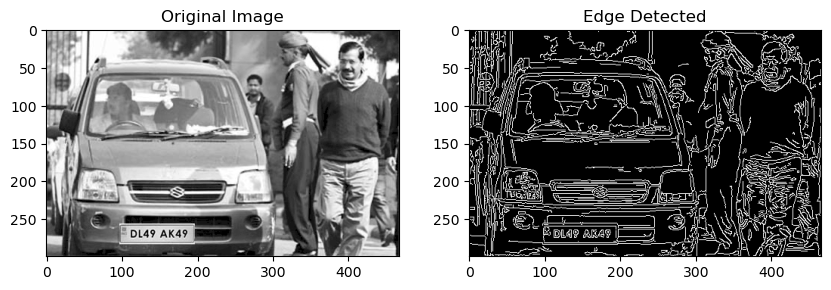

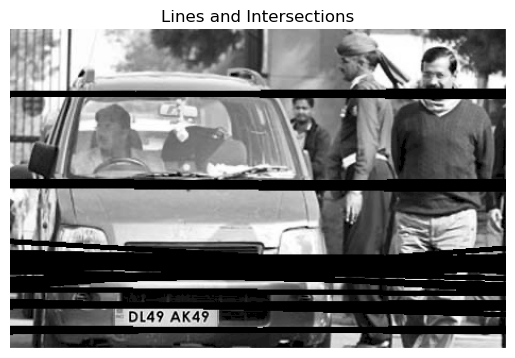

In [17]:
def main(work_dir):
    DATASET_PATH = Path(work_dir) / "dataset"
    IMAGES_PATH = DATASET_PATH / "images"
    RESULTS_PATH = Path(work_dir) / "results"

    # Ensure the results directory exists
    RESULTS_PATH.mkdir(exist_ok=True)

    # Load image paths
    png_img_list = list(IMAGES_PATH.glob("*.png"))

    # Example: Process a single selected image for demonstration
    selected_image_path = str(np.random.choice(png_img_list))

    image = cv2.imread(selected_image_path, cv2.IMREAD_GRAYSCALE)
    canny_edges = cv2.Canny(image, 100, 200)  # Adjust thresholds as needed

    lines = hough_lines(canny_edges)
    horizontal_lines, vertical_lines = group_lines_by_orientation(lines)
    intersections = find_intersections(horizontal_lines, vertical_lines)

    # Display original image and edges
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(image, cmap="gray"), plt.title("Original Image")
    plt.subplot(122), plt.imshow(canny_edges, cmap="gray"), plt.title("Edge Detected")
    plt.show()

    # Define a function to convert (rho, theta) to endpoint coordinates

    def line_endpoints(rho, theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        return x1, y1, x2, y2

    # Draw the lines onto the image
    for rho, theta in lines:
        x1, y1, x2, y2 = line_endpoints(rho, theta)
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 3)

    # Assuming `intersections` is a list of (x, y) tuples
    for x, y in intersections:
        cv2.circle(image, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)

    # Display the result
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Lines and Intersections")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    work_dir = "/Users/emre/GitHub/HU-AI/AIN433/Assignment 1/"
    main(work_dir)

In [14]:
def main(work_dir):
    DATASET_PATH = os.path.join(work_dir, "dataset")
    IMAGES_PATH = os.path.join(DATASET_PATH, "images")
    ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
    RESULTS_PATH = os.path.join(work_dir, "results")

    # Ensure the results directory exists
    os.makedirs(RESULTS_PATH, exist_ok=True)

    # Load image paths
    png_img_list = [img for img in glob.glob(os.path.join(IMAGES_PATH, "*.png"))]
    print(f"Number of images: {len(png_img_list)}")

    # Load XML annotations into a dictionary
    xml_coordinates = {
        Path(ET.parse(xml_file).find("filename").text).stem: [
            int(ET.parse(xml_file).find(".//xmin").text),
            int(ET.parse(xml_file).find(".//ymin").text),
            int(ET.parse(xml_file).find(".//xmax").text),
            int(ET.parse(xml_file).find(".//ymax").text),
        ]
        for xml_file in glob.glob(os.path.join(ANNOTATIONS_PATH, "*.xml"))
    }

    # Choose a random image from the list
    selected_image_path = np.random.choice(png_img_list)

    # Apply Sobel edge detector to the selected image
    sobel_img, grad_x, grad_y = sobel_edge_detector(selected_image_path)

    # Apply Canny edge detection to the selected image
    canny_edges = canny_edge_detector(selected_image_path)

    # Display the original and Sobel edge detected images
    original_img = cv2.imread(selected_image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img_rgb)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(sobel_img, cmap="gray")
    plt.axis("off")
    plt.title("Sobel Edge Detection Result")

    plt.subplot(1, 3, 3)
    plt.imshow(canny_edges, cmap="gray")
    plt.axis("off")
    plt.title("Canny Edge Detection Result")

    plt.show()

    # Perform Hough transform on the Canny edge-detected image
    canny_lines = hough_lines(canny_edges)

    # Visualize the Hough lines on the original image
    canny_lines_img = np.copy(original_img)
    draw_lines(canny_lines_img, canny_lines)

    # Perform Hough transform on the Sobel edge-detected image
    sobel_lines = hough_lines(sobel_img)

    # Visualize the Hough lines on the original image
    sobel_lines_img = np.copy(original_img)
    draw_lines(sobel_lines_img, sobel_lines)

    # Show them side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 6))
    axes[0].imshow(cv2.cvtColor(canny_lines_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Hough Lines (Canny)")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(sobel_lines_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Hough Lines (Sobel)")
    axes[1].axis("off")

    plt.show()

    # Process each image
    for img_path in png_img_list:
        image_name = Path(img_path).stem
        real_coordinates = xml_coordinates.get(image_name)

        if real_coordinates is None:
            print(f"No annotation found for image: {image_name}")
            continue

        image = cv2.imread(img_path)

        # Sobel and Canny edge detection processes can go here
        # Example with Canny (for brevity, assuming canny_edge_detector function is defined):
        # Inside your loop for processing each image
        canny_edges = canny_edge_detector(
            img_path, kernel_size=5, low_threshold_ratio=0.1, high_threshold_ratio=0.5
        )
        # Perform Hough transform here to get lines
        lines = hough_lines(
            canny_edges
        )  # Ensure this matches your Hough transform function's signature and return format

        # print(
        #     f"Image: {image_name}, Edge-detected image shape: {canny_edges.shape}, Canny edges: {canny_edges}"
        # )

        # Assuming a modified version of predict_plate that accepts actual image array and real coordinates directly
        iou = predict_plate(image, lines, real_coordinates)
        print(f"Image: {image_name}, Intersection over Union (IoU): {iou}")

        # Optionally, save the edge-detected images and/or results
        cv2.imwrite(os.path.join(RESULTS_PATH, f"{image_name}_edges.png"), canny_edges)

        # Add any additional processing or result saving here

Number of images: 433


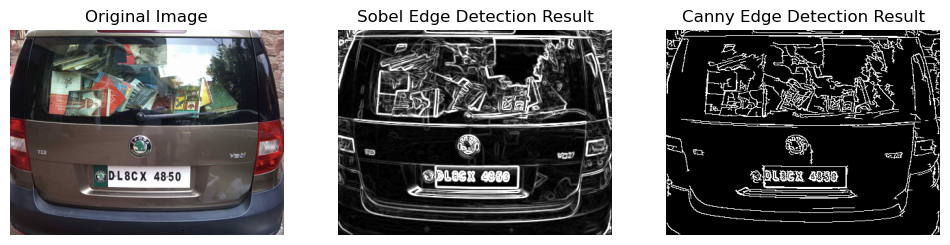

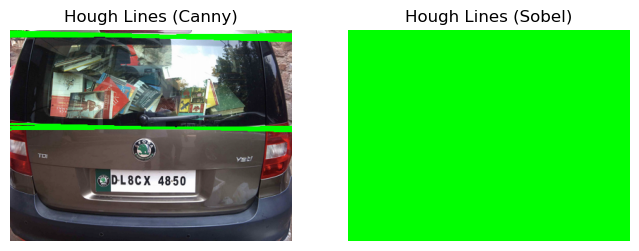

No lines detected in the image, or lines did not modify the mask as expected.


UnboundLocalError: local variable 'x_top' referenced before assignment

In [15]:
if __name__ == "__main__":
    work_dir = "/Users/emre/GitHub/HU-AI/AIN433/Assignment 1/"
    main(work_dir)